In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack
from scipy.ndimage.filters import gaussian_filter

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap import predictions
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

## Fraction of in-situ and ex-situ stars

In [3]:
test_dir = '../model/'
model_str = 'final_6'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_%s.yaml' % model_str)

# The results of the final sampling process
result_file = os.path.join(test_dir, 'asap_test_%s_sample.npz' % model_str)

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

# Load in the final sampling results
(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = io.load_npz_results(result_file)

_, n_step, n_dim = mod_result_chains.shape

mod_result_best = np.nanmean(mod_result_chains[:, -int(n_step * 0.1):, :].reshape([-1, n_dim]), axis=0)

# Predict the stellar mass in inner and outer apertures
logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], mod_result_best, min_logms=10.5,
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

# Predict the SMFs and DeltaSigma profiles
um_smf_tot, um_smf_inn, um_dsigma = make_model_predictions(
    mod_result_best, cfg, obs_data, um_data)

# Check the likelihood for SMF and DeltaSigma profiles
lnlike_smf, lnlike_dsigma = ln_likelihood(
    mod_result_best, cfg, obs_data, um_data, sep_return=True)

# The useful part of the mock catalog
um_mock_use = um_data['um_mock'][mask_use]

print("\n# Best parameters: ", mod_result_best)
print("# ln(Likelihood) for SMFs   : %8.4f" % lnlike_smf)
print("# ln(Likelihood) for DSigma : %8.4f" % lnlike_dsigma)

print("\n", mod_result_best)

# Running model: asap_test_final_6
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   200 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for  9000 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total 

### Relation between halo mass and ex-situ fraction within inner 10 kpc

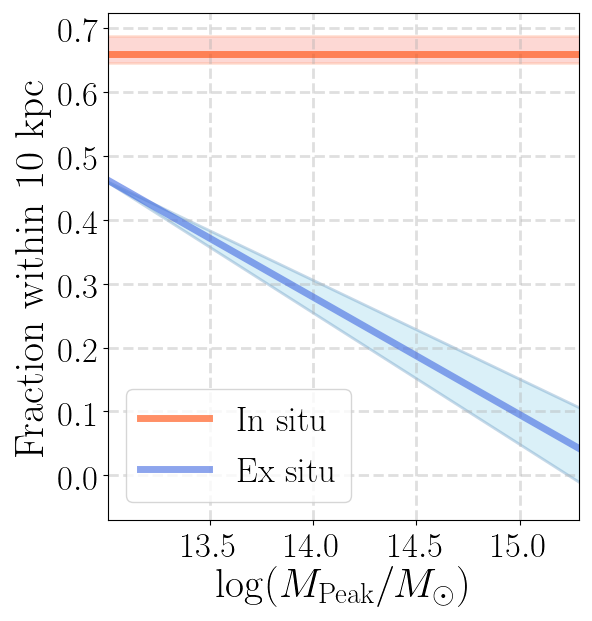

In [4]:
fig_1 = plt.figure(figsize=(6, 6))
fig_1.subplots_adjust(left=0.21, right=0.995, bottom=0.15, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

f_ins = mod_result_best[4]
f_ins_upp = np.max(mod_result_samples[:, 4])
f_ins_low = np.min(mod_result_samples[:, 4])

a_exs, b_exs = mod_result_best[5], mod_result_best[6]
a_exs_low = np.min(mod_result_samples[:, 5])
a_exs_upp = np.max(mod_result_samples[:, 5])
b_exs_low = np.min(mod_result_samples[:, 6])
b_exs_upp = np.max(mod_result_samples[:, 6])

ax1.fill_between([12.5, 15.7], [f_ins_low, f_ins_low], [f_ins_upp, f_ins_upp],
                 facecolor='salmon', edgecolor='lightsalmon', linewidth=2,
                 alpha=0.3, label='__no_label__')

ax1.axhline(0.659, linestyle='-', linewidth=5.0, alpha=0.6, c='orangered',
            label=r'$\mathrm{In\ situ}$')

logmh_arr = np.linspace(13.0, 15.4, 50)
exsitu_frac_0 = a_exs * (logmh_arr - 13.5) + b_exs
exsitu_frac_1 = a_exs_upp * (logmh_arr - 13.5) + b_exs_upp
exsitu_frac_2 = a_exs_low * (logmh_arr - 13.5) + b_exs_low

ax1.fill_between(logmh_arr, exsitu_frac_1, exsitu_frac_2,
                 facecolor='skyblue', edgecolor='steelblue', linewidth=2,
                 alpha=0.3, label='__no_label__')

ax1.plot(logmh_arr, exsitu_frac_0, linewidth=5.0, alpha=0.6, c='royalblue',
         label=r'$\mathrm{Ex\ situ}$')

ax1.set_xlim(13.01, 15.29)

ax1.legend(loc='lower left', fontsize=25)

_ = ax1.set_xlabel(r'$\log (M_{\mathrm{Peak}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\mathrm{Fraction\ within\ 10\ kpc}$', fontsize=30)

### Relation between stellar mass and overall ex-situ fraction

In [5]:
um_mock_use = um_data['um_mock'][mask_use]

# Mask for central galaxies
mask_cen = um_mock_use['upid'] == -1

# Overall fraction of in-situ and ex-situ stars
frac_ins = um_mock_use[mask_cen]['sm'] / um_mock_use[mask_cen]['mtot_galaxy']
frac_exs = um_mock_use[mask_cen]['icl'] / um_mock_use[mask_cen]['mtot_galaxy']

logms_mod_ins_all = logms_tot[mask_cen] + np.log10(frac_ins)
logms_mod_exs_all = logms_tot[mask_cen] + np.log10(frac_exs)

logms_mod_ins_10kpc = (logms_mod_ins_all + np.log10(f_ins))
logms_mod_exs_10kpc = (logms_mod_exs_all + np.log10(a_exs * (um_mock_use['logmh_peak'][mask_cen] - 13.5) + b_exs))

frac_exs_10kpc = ((10.0 ** logms_mod_exs_10kpc) / (10.0 ** logms_mod_ins_10kpc + 10.0 ** logms_mod_exs_10kpc))

In [6]:
logms_bin = np.linspace(11.4, 12.2, 10)

# For central
idx_logms_cen = np.digitize(logms_tot[mask_cen], logms_bin)


avg_mass = np.asarray([np.nanmean(logms_tot[mask_cen][idx_logms_cen == k])
                       for k in range(len(logms_bin))])


avg_frac = np.asarray([np.nanmean(frac_exs[idx_logms_cen == k])
                       for k in range(len(logms_bin))])
f16_frac = np.asarray([np.nanpercentile(frac_exs[idx_logms_cen == k], 16)
                       for k in range(len(logms_bin))])
f84_frac = np.asarray([np.nanpercentile(frac_exs[idx_logms_cen == k], 84)
                       for k in range(len(logms_bin))])

avg_frac_10kpc = np.asarray([np.nanmean(frac_exs_10kpc[idx_logms_cen == k])
                             for k in range(len(logms_bin))])
f16_frac_10kpc = np.asarray([np.nanpercentile(frac_exs_10kpc[idx_logms_cen == k], 16)
                             for k in range(len(logms_bin))])
f84_frac_10kpc = np.asarray([np.nanpercentile(frac_exs_10kpc[idx_logms_cen == k], 84)
                             for k in range(len(logms_bin))])

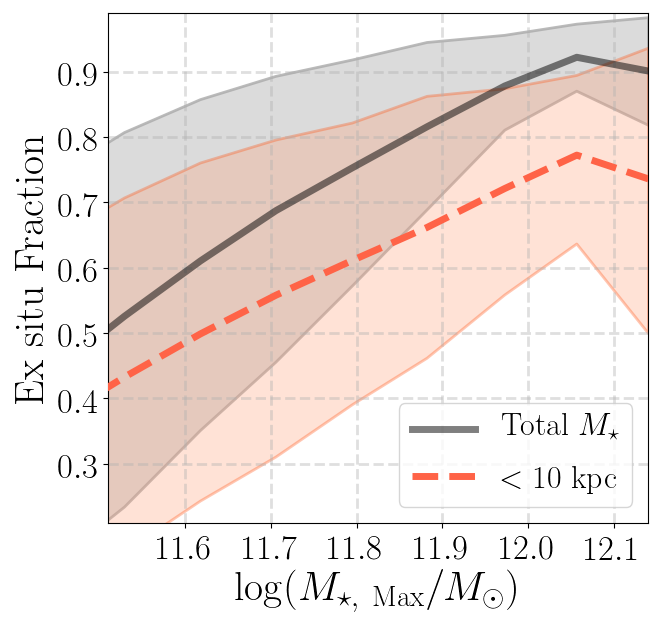

In [7]:
fig_2 = plt.figure(figsize=(6.5, 6))
fig_2.subplots_adjust(left=0.165, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_2.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax1.fill_between(avg_mass, f16_frac, f84_frac,
                 facecolor='lightgray', edgecolor='darkgray', linewidth=2,
                 alpha=0.8, label='__no_label__', zorder=0)

ax1.fill_between(avg_mass, f16_frac_10kpc, f84_frac_10kpc,
                 facecolor='lightsalmon', edgecolor='orangered', linewidth=2,
                 alpha=0.3, label='__no_label__', zorder=1)
    
ax1.plot(avg_mass, avg_frac, linestyle='-', c='k', linewidth=5.0,
         label=r'$\mathrm{Total\ }M_{\star}$', zorder=10, alpha=0.5)

ax1.plot(avg_mass, avg_frac_10kpc, linestyle='--', c='tomato', linewidth=5.0,
         label=r'$<\mathrm{10\ kpc}$', zorder=11)

ax1.set_xlim(11.51, 12.14)
ax1.set_ylim(0.21, 0.99)

ax1.legend(loc='lower right', fontsize=23)

_ = ax1.set_xlabel(r'$\log (M_{\star,\ \mathrm{Max}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\mathrm{Ex\ situ\ Fraction}$', fontsize=30)

### Relation between halo mass and overall ex-situ fraction

In [9]:
tng_tot = Table.read('../data/tng_m200c_fexs_total.txt', format='ascii')
tng_10 = Table.read('../data/tng_m200c_fexs_10kpc.txt', format='ascii')

logmh_bin = np.linspace(12.8, 15.2, 12)

# For central
idx_logmh_cen = np.digitize(um_mock_use['logmh_vir'][mask_cen], logmh_bin)


avg_mass = np.asarray([np.nanmean(um_mock_use['logmh_vir'][mask_cen][idx_logmh_cen == k])
                       for k in range(len(logmh_bin))])

avg_frac = np.asarray([np.nanmean(frac_exs[idx_logmh_cen == k])
                       for k in range(len(logmh_bin))])
f16_frac = np.asarray([np.nanpercentile(frac_exs[idx_logmh_cen == k], 16)
                       for k in range(len(logmh_bin))])
f84_frac = np.asarray([np.nanpercentile(frac_exs[idx_logmh_cen == k], 84)
                       for k in range(len(logmh_bin))])

avg_frac_10kpc = np.asarray([np.nanmean(frac_exs_10kpc[idx_logmh_cen == k])
                             for k in range(len(logmh_bin))])
f16_frac_10kpc = np.asarray([np.nanpercentile(frac_exs_10kpc[idx_logmh_cen == k], 16)
                             for k in range(len(logmh_bin))])
f84_frac_10kpc = np.asarray([np.nanpercentile(frac_exs_10kpc[idx_logmh_cen == k], 84)
                             for k in range(len(logmh_bin))])

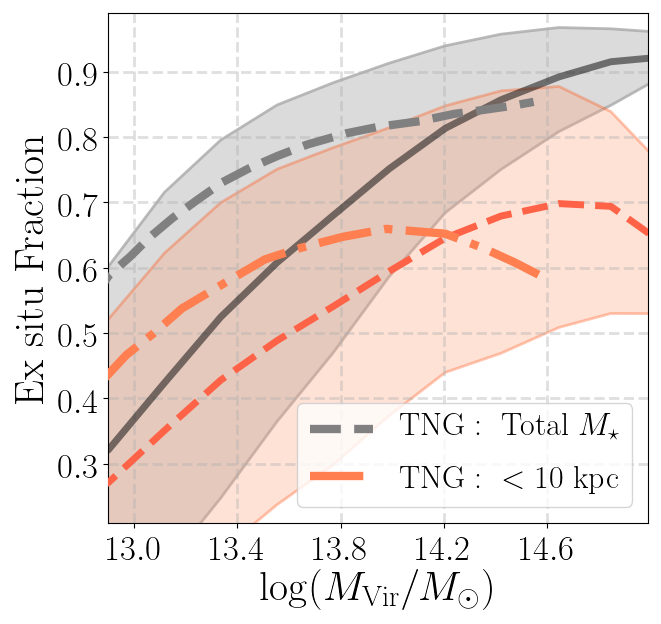

In [10]:
fig_3 = plt.figure(figsize=(6.5, 6))
fig_3.subplots_adjust(left=0.165, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_3.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

ax1.xaxis.set_ticks([13.0, 13.4, 13.8, 14.2, 14.6])

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax1.fill_between(avg_mass, f16_frac, f84_frac,
                 facecolor='lightgray', edgecolor='darkgray', linewidth=2,
                 alpha=0.8, label='__no_label__', zorder=0)

ax1.fill_between(avg_mass, f16_frac_10kpc, f84_frac_10kpc,
                 facecolor='lightsalmon', edgecolor='orangered', linewidth=2,
                 alpha=0.3, label='__no_label__', zorder=1)
    
ax1.plot(avg_mass, avg_frac, linestyle='-', c='k', linewidth=5.0,
         label='__no_label__', zorder=10, alpha=0.5)

ax1.plot(avg_mass, avg_frac_10kpc, linestyle='--', c='tomato', linewidth=5.0,
         label='__no_label__', zorder=11)


ax1.plot(np.log10(tng_tot['col1']), tng_tot['col2'], linestyle='--', 
         c='gray', linewidth=6.0, label=r'$\mathrm{TNG:\ Total}\ M_{\star}$', zorder=11)
ax1.plot(np.log10(tng_10['col1']), tng_10['col2'], linestyle='-.', 
         c='coral', linewidth=6.0, label=r'$\mathrm{TNG:\ }< 10\ \mathrm{kpc}$', zorder=11)

ax1.set_xlim(12.90, 14.99)
ax1.set_ylim(0.21, 0.99)

ax1.legend(loc='lower right', fontsize=23)

_ = ax1.set_xlabel(r'$\log (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\mathrm{Ex\ situ\ Fraction}$', fontsize=30)

### Save the figures

In [11]:
fig_2.savefig('fig/fig8_a.pdf', dpi=150)

fig_3.savefig('fig/fig8_b.pdf', dpi=150)